In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from collections import Counter

In [10]:
class ion(object):
    
    def __init__(self,ion_name,valence,IO):
        """ Initialize ion object.
        Inputs are
        ion_name: the type of ion (string)
        valence: number of valence electrons (int)
        location: string, either in or out
        """
        self.ion_name = ion_name
        self.valence = valence
        self.IO = IO
        if IO == 'in':
            self.position = (rd.uniform(-0.99,-0.02),rd.uniform(0.01,0.99))
        else:
            self.position = (rd.uniform(0.02,0.99),rd.uniform(0.01,0.99))
        
    def get_name(self):
        return(self.ion_name)
    
    def get_position(self):
        return(self.position)

In [11]:
class Nernst():

    def find_potential(self,T,z,Xi,Xo):
        """
        T: Temperature in Kelvin
        z: Valence electrons of ion
        Xi: Inner membrane concentration (mM)
        Xo: Outer membrane concentration (mM)
        returns: Membrane potential for single species
        """
        membranePotential = (8.314*T)/(z*96485)*np.log(Xo/Xi)
        return membranePotential
    
    def plot_potential(self,volts,name,color):
        '''
        This function plots the potential across a membrane
        volts: Float, The voltage potential calculated by find_potential
        name: String, The name of the ionic species
        '''
        points = [0,1,2,3]
        values= [0,0,volts,volts]
        plt.scatter(points,values,label=name,color=color)
        plt.plot(points,values,color=color)
        plt.xlim(0,3)
        plt.ylim(-100,100)
        xlabs = np.arange(0, 4, 1.0)
        x_tick_names = ['','Channel Closed', 'Channel Open','']
        plt.xticks(xlabs,x_tick_names,color='lightgray')
        plt.yticks(color='lightgray')
        plt.text(2, volts+3, str(round(volts, 2)))
        plt.xlabel("Membrane Permeability",color='lightgray')
        plt.ylabel("Voltage (mV)",color='lightgray')
        plt.grid(color="white", linestyle='-', linewidth=0.2)
        plt.legend(facecolor='black',edgecolor='lightgray')
        
    def plot_positions(self,ion_object_list,colors,names):
        '''
        This function takes in a list of ion objects, and plots them on a
        scatterplot. All ions of the same name are given the same color, but
        said color is random. Also returns a variable (called unique_colors)
        with a list of colors corresponding to the different ionic species in solution.
        '''
        for i,obj in enumerate(ion_object_list):
            position = obj.get_position()
            if obj.get_name() == ion_object_list[i-1].get_name():
                plt.scatter(position[0],position[1],color=colors[i])
            else:
                plt.scatter(position[0],position[1],color=colors[i],label=names[i])
        plt.plot([0,0],[0,1.1],c='salmon',linewidth=2,label='Membrane')
        
        xlabs = np.arange(-1.0,1.0,0.5)
        x_tick_names = ['','In','','Out']
        plt.xticks(xlabs,x_tick_names,color='lightgray')
        plt.xlim(-1,1)
        plt.ylim(0,1.01)
        plt.title('Distrubution of Ions',color='lightgray')
        plt.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
        plt.legend(facecolor='black',edgecolor='lightgray')

    def entropy(self,mol_dict,volume=1):
        '''
        This function takes 1 input, that is the molarity dictionary. Using this
        it finds the entropy change before and after the ion channels push ions across
        the membrane.
        '''
        quanta = 5 #This is an arbitrary number, do not change
        boltzmann = 1.38E-23
        mass_water = volume * 1000
        mols_water = mass_water / 18.02
        inside = 0
        outside = 0
        for key in mol_dict:
            for i,j in enumerate(mol_dict[key][1:]):
                if i%2 != 0:
                    outside += j
                else:
                    inside += j
        inside = int(round(inside + mols_water))
        outside  = int(round(outside + mols_water))
        total_mols = int(round(inside + outside))

        micro_init = 2*(np.math.factorial(int(total_mols/2))/(np.math.factorial(quanta)*((int(total_mols/2))-quanta)))
        micro_final = np.math.factorial(inside)/(np.math.factorial(quanta)*(inside-quanta)) + np.math.factorial(outside)/(np.math.factorial(quanta)*(outside-quanta))

        ent_init = np.log(micro_init)
        ent_final = np.log(micro_final)
        change = ent_final - ent_init
        
        plt.xlim(0,3)
        plt.ylim(ent_init-2,ent_final+2)
        xlabs = np.arange(0, 4, 1.0)
        x_tick_names = ['','Channel Closed', 'Channel Open','']
        points = [0,1,2,3]
        values= [ent_init,ent_init,ent_final,ent_final]
        plt.plot(points,values,color='salmon')
        plt.scatter(points,values,color='salmon')
        plt.xticks(xlabs,x_tick_names,color='lightgray')
        plt.yticks(color='lightgray')
        plt.title(f'Change in Entropy: {change} Joules')
        plt.text(0.85, ent_init+0.3, str(round(ent_init, 2)))
        plt.text(2.01, ent_final+0.3, str(round(ent_final, 2)))
        plt.xlabel("Membrane Permeability",color='lightgray')
        plt.ylabel("Joules",color='lightgray')
        plt.grid(color="white", linestyle='-', linewidth=0.2)
        return change
        
    def setup(self,mol_dict,total_particles=100):
        '''
        This function takes in a dictionary with ionic species as the key,
        the valence electrons in the first column, concentration inside the cell
        in the second, and the concentration outside the cell in the third and returns
        a list of objects that is proportional to the concentrations. The returned list
        also has all of the correct attributes such that they can be easily plotted.
        Has no effect on the potential.
        '''
        total_particles = total_particles
        ion_object_list = []

        total = 0
        for key in mol_dict:
            for value in mol_dict[key][1:]:
                total += value

        chunk_size = total_particles / total
        
        for key in mol_dict:
            for i,dont_use in enumerate(mol_dict[key][1:]):
                num_ions = int(round(mol_dict[key][i+1]*chunk_size,0))
                for j in range(num_ions):
                    if i%2 != 0:
                        ion_object_list.append(ion(key,mol_dict[key][0],'out'))
                    else:
                        ion_object_list.append(ion(key,mol_dict[key][0],'in'))

        names = []
        colors = []
        [names.append(x.get_name()) for x in ion_object_list]
        counted = dict(Counter(names))
        for key in counted:
            color = "#"+''.join([rd.choice('0123456789ABCDEF') for j in range(6)])
            for i in range(counted[key]):
                colors.append(color)

        unique_colors = list(set(colors))

        return(ion_object_list,unique_colors,colors,names)
    
Nernst = Nernst()

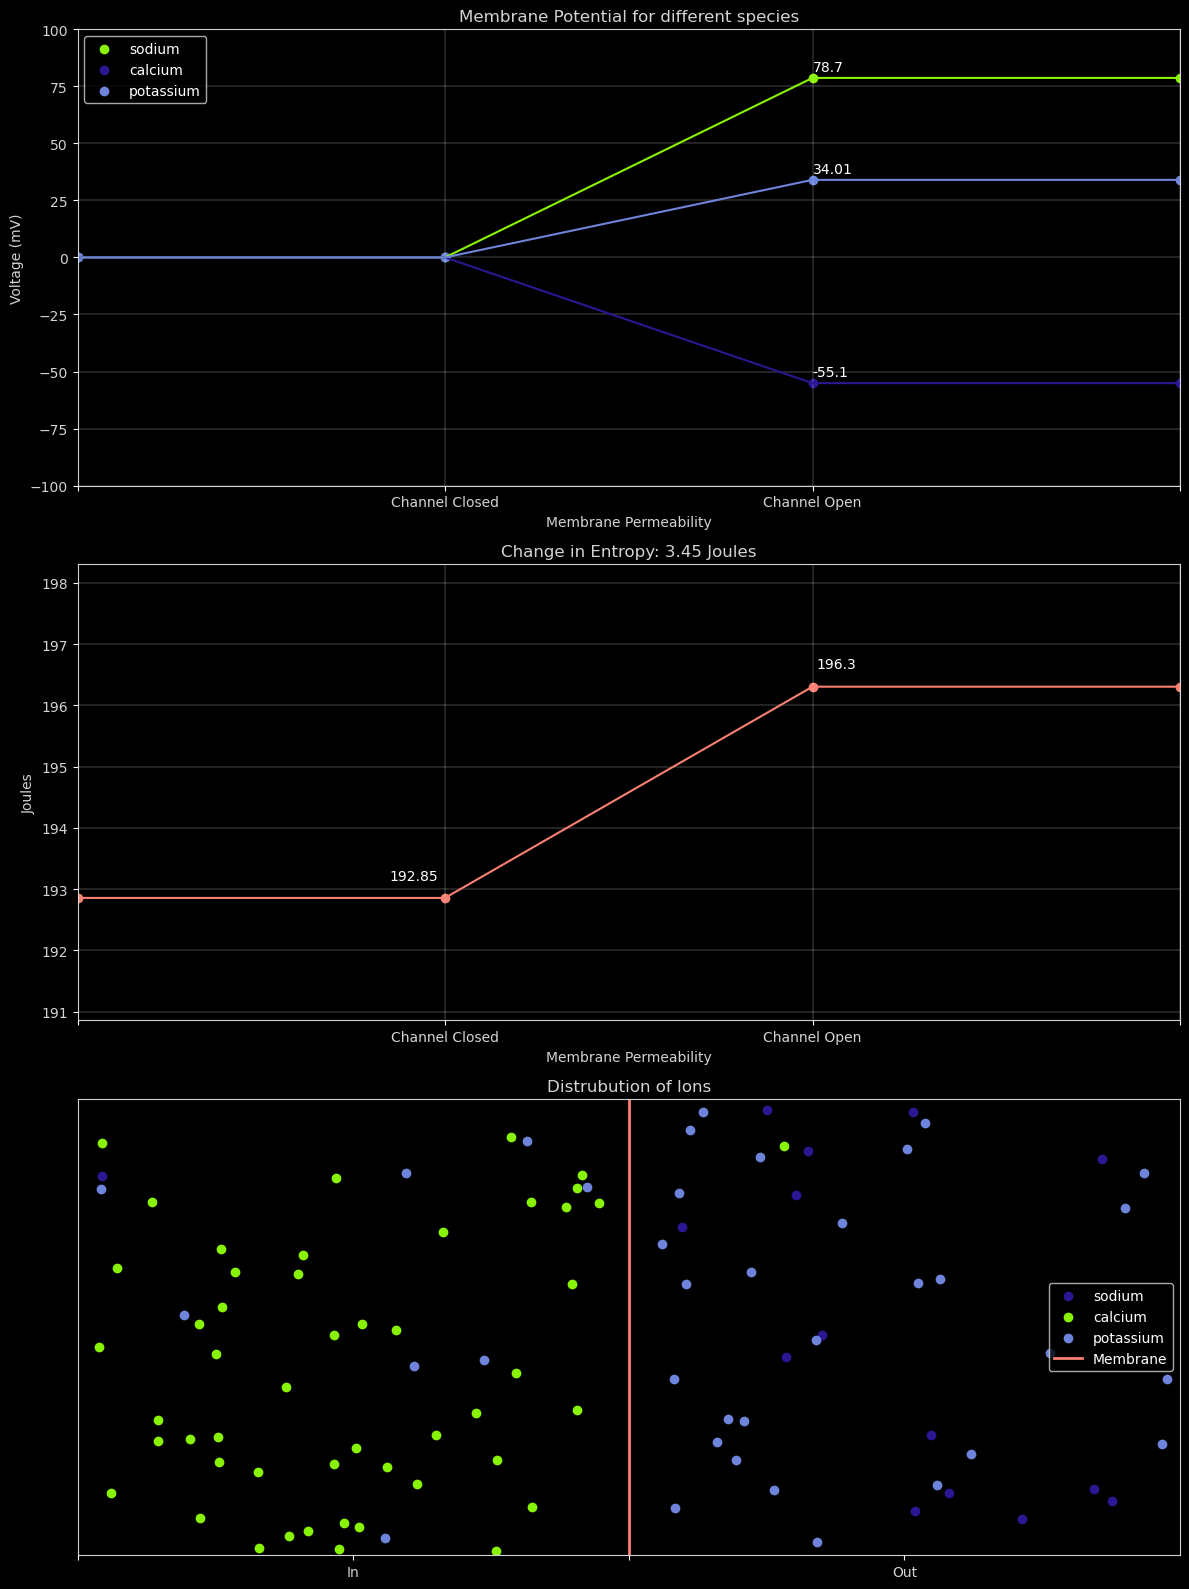

In [14]:
if __name__ == '__main__':
    temp = 300

    molarity_dict = {
#                  z  #in  #out
        'sodium': (1, 0.1, 2.1),
        'calcium': (2, 7.1, 0.1),
        'potassium': (1, 1.1, 4.1),
    }
        
    ion_object_list,unique_colors,colors,names = Nernst.setup(molarity_dict,total_particles=100)
    figure, ax = plt.subplots(3,1,figsize=(12,16))

    plt.subplot(311)
    plt.style.use('dark_background')
    ax[0].set_facecolor('black')
    for i,key in enumerate(molarity_dict):
        z = molarity_dict[key][0]
        inside = molarity_dict[key][1]
        outside = molarity_dict[key][2]
        potential = Nernst.find_potential(temp,z,inside,outside)
        Nernst.plot_potential(potential*1000,key,unique_colors[i])
    plt.title(f'Membrane Potential for different species',color='lightgray')

    plt.subplot(312)
    plt.style.use('dark_background')
    ax[1].set_facecolor('black')
    change = Nernst.entropy(molarity_dict)
    plt.title(f'Change in Entropy: {round(change,2)} Joules',color='lightgray')

    plt.subplot(313)
    plt.style.use('dark_background')
    ax[2].set_facecolor('black')
    Nernst.plot_positions(ion_object_list,colors,names)

    plt.tight_layout()
    plt.style.use('dark_background')

    for plot in ax:
        for spine in plot.spines.values():
            spine.set_edgecolor('lightgray')